# B-splines FEM solver for Poisson equation

For this session, we'll need to install the [spl](https://github.com/pyccel/spl) *python* package. Please follow the *README* file installation instructions.

## 1-D Poisson solver

Let's first define the assembly procedures for the stiffness matrix and the rhs.

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like
from matplotlib.pyplot import plot, show
%matplotlib inline

In [2]:
# ... assembling the stiffness matrix using stencil forms
def assemble_stiffness(V):

    # ... sizes
    [s1] = V.vector_space.starts
    [e1] = V.vector_space.ends
    [p1] = V.vector_space.pads

    k1 = V.quad_order
    spans_1 = V.spans
    basis_1 = V.basis
    weights_1 = V.weights
    # ...

    # ... data structure
    stiffness = zeros((V.nbasis, V.nbasis))
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1  - 1 + il_1
                j1 = i_span_1 - p1  - 1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[il_1, 0, g1, ie1]
                    bi_x = basis_1[il_1, 1, g1, ie1]

                    bj_0 = basis_1[jl_1, 0, g1, ie1]
                    bj_x = basis_1[jl_1, 1, g1, ie1]

                    wvol = weights_1[g1, ie1]

                    v += (bi_x * bj_x) * wvol

                stiffness[i1, j1]  += v
    # ...

    # ...
    return stiffness
    # ...
# ...

In [3]:
# ... Assembly procedure for the rhs
def assemble_rhs(V, f):

    # ... sizes
    [s1] = V.vector_space.starts
    [e1] = V.vector_space.ends
    [p1] = V.vector_space.pads

    k1 = V.quad_order
    spans_1 = V.spans
    basis_1 = V.basis
    points_1 = V.points
    weights_1 = V.weights
    # ...

    # ... data structure
    rhs = zeros(V.nbasis)
    # ...

    # ... build rhs
    for ie1 in range(s1, e1+1-p1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            i1 = i_span_1 - p1  - 1 + il_1

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis_1[il_1, 0, g1, ie1]
                bi_x = basis_1[il_1, 1, g1, ie1]

                x1    = points_1[g1, ie1]
                wvol  = weights_1[g1, ie1]

                v += bi_0 * f(x1) * wvol

            rhs[i1] += v
    # ...

    # ...
    return rhs
    # ...
# ...

---
**Note**: 
We added the function **f** as an argument of the *assemble_rhs* function. In general, we will avoid calling a function over the quadrature points for performance reasons. Setting directly the arithemtic expression makes life easier for compilers! 

---

Now, let's create a B-spline Finite Element Space $V$ over a grid of $32$ elements, and using **cubic** *B-splines*

In [4]:
# nedded imports
from spl.fem.splines import SplineSpace

In [5]:
p  = 3    # spline degree
ne = 32   # number of elements

grid = linspace(0., 1., ne+1)
    
# create a finite element space
V = SplineSpace(p, grid=grid)

### Analytical solution

In finite elements, one of the first tests we do is to check polynomial solutions of with a degree that smaller or equal to the one we chose for our discretization.
Here, we take the analytical solution $u(x) = x*(1-x)$ which leads to the rhs $f(x) = - \partial_{xx} u(x) = 2$.

In [6]:
# assembly
stiffness = assemble_stiffness(V)
rhs = assemble_rhs(V, lambda x: 2.)

In order to apply the homogeneous Dirichlet boundary conditions, we only have to remove the first and the last splines, since their values at the boundary is $1$. Due to the partition of unity, the remaining splines are $0$ on the boundary.

In [7]:
# apply homogeneous dirichlet boundary conditions
rhs = rhs[1:-1]
stiffness = stiffness[1:-1, 1:-1]

---
**Note**:

Later, we will show how to do this directly in the Spline space and have this information transfered to our data structures *StencilMatrix* and *StencilVector*.

---

In [8]:
from scipy.sparse.linalg import cg
u, info = cg( stiffness, rhs, tol=1e-6, maxiter=5000 )

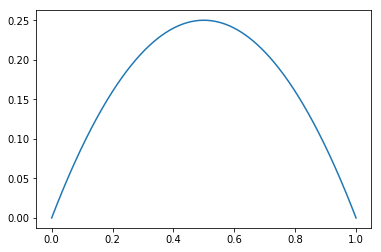

In [9]:
# TODO - to be replaced by the Field evaluation
#      - implement setfromarray 
from scipy.interpolate import splev

def evaluate_field(u, x):
    cu = zeros_like(V.knots)
    # we add a shift because of the homogeneous bc
    cu[1:1+len(u)] = u[:]
    tck = (V.knots, cu, p)
    y = splev( x, tck )
    return y

grid = linspace(0., 1., 401)
plot(grid, evaluate_field(u, grid)) ; show()

## Improving the assembly procedure

---
**Note**:

From now on, we will use our data structure *StencilMatrix* and *StencilVector* to store the matrix and rhs entries.

---


In [10]:
from spl.linalg.stencil import StencilVector, StencilMatrix

### 2-D case

We present here different assembly procedures.

- *assembly_v0*: similar to the **1D** case, but using the *Stencil* format to reduce memory consumption,
- *assembly_v1*: we extract the loop over the quadrature points and put it as a function that we call **kernel**. In this case, we need the function *kernel_b*,
- *assembly_v2*: we extract the nested loops over the non-vanishing splines with respect to the current element and put them in a new kernel, called *kernel_b*. We also introduce an **element matrix** to store all these entries,
- *assembly_v3*: we avoid setting the entries into the matrix one by one. In this case, we use *numpy* copy of arrays, modulo a specific shift.

In [11]:
def assembly_v0(V):

    # ... sizes
    [s1, s2] = V.vector_space.starts
    [e1, e2] = V.vector_space.ends
    [p1, p2] = V.vector_space.pads
    # ...

    # ... seetings
    [k1, k2] = [W.quad_order for W in V.spaces]
    [spans_1, spans_2] = [W.spans for W in V.spaces]
    [basis_1, basis_2] = [W.basis for W in V.spaces]
    [weights_1, weights_2] = [W.weights for W in V.spaces]
    [points_1, points_2] = [W.points for W in V.spaces]
    # ...

    # ... data structure
    M = StencilMatrix(V.vector_space, V.vector_space)
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        for ie2 in range(s2, e2+1-p2):
            i_span_1 = spans_1[ie1]
            i_span_2 = spans_2[ie2]
            for il_1 in range(0, p1+1):
                for jl_1 in range(0, p1+1):
                    for il_2 in range(0, p2+1):
                        for jl_2 in range(0, p2+1):

                            i1 = i_span_1 - p1  - 1 + il_1
                            j1 = i_span_1 - p1  - 1 + jl_1

                            i2 = i_span_2 - p2  - 1 + il_2
                            j2 = i_span_2 - p2  - 1 + jl_2

                            v_s = 0.0
                            for g1 in range(0, k1):
                                for g2 in range(0, k2):
                                    bi_0 = basis_1[il_1, 0, g1, ie1] * basis_2[il_2, 0, g2, ie2]
                                    bi_x = basis_1[il_1, 1, g1, ie1] * basis_2[il_2, 0, g2, ie2]
                                    bi_y = basis_1[il_1, 0, g1, ie1] * basis_2[il_2, 1, g2, ie2]

                                    bj_0 = basis_1[jl_1, 0, g1, ie1] * basis_2[jl_2, 0, g2, ie2]
                                    bj_x = basis_1[jl_1, 1, g1, ie1] * basis_2[jl_2, 0, g2, ie2]
                                    bj_y = basis_1[jl_1, 0, g1, ie1] * basis_2[jl_2, 1, g2, ie2]

                                    wvol = weights_1[g1, ie1] * weights_2[g2, ie2]

                                    v_s += (bi_x * bj_x + bi_y * bj_y) * wvol

                            M[i1, i2, j1 - i1, j2 - i2]  += v_s
    # ...

In [12]:
def assembly_v1(V, kernel):

    # ... sizes
    [s1, s2] = V.vector_space.starts
    [e1, e2] = V.vector_space.ends
    [p1, p2] = V.vector_space.pads
    # ...

    # ... seetings
    [k1, k2] = [W.quad_order for W in V.spaces]
    [spans_1, spans_2] = [W.spans for W in V.spaces]
    [basis_1, basis_2] = [W.basis for W in V.spaces]
    [weights_1, weights_2] = [W.weights for W in V.spaces]
    [points_1, points_2] = [W.points for W in V.spaces]
    # ...

    # ... data structure
    M = StencilMatrix(V.vector_space, V.vector_space)
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        for ie2 in range(s2, e2+1-p2):
            i_span_1 = spans_1[ie1]
            i_span_2 = spans_2[ie2]
            for il_1 in range(0, p1+1):
                for jl_1 in range(0, p1+1):
                    for il_2 in range(0, p2+1):
                        for jl_2 in range(0, p2+1):

                            i1 = i_span_1 - p1  - 1 + il_1
                            j1 = i_span_1 - p1  - 1 + jl_1

                            i2 = i_span_2 - p2  - 1 + il_2
                            j2 = i_span_2 - p2  - 1 + jl_2

                            bi1 = basis_1[il_1, :, :, ie1]
                            bi2 = basis_2[il_2, :, :, ie2]

                            bj1 = basis_1[jl_1, :, :, ie1]
                            bj2 = basis_2[jl_2, :, :, ie2]

                            w1 = weights_1[:, ie1]
                            w2 = weights_2[:, ie2]

                            v_s = kernel(k1, k2, bi1, bi2, bj1, bj2, w1, w2)
                            M[i1, i2, j1 - i1, j2 - i2]  += v_s
    # ...

In [13]:
def kernel_a(k1, k2, bi1, bi2, bj1, bj2, w1, w2):
    v = 0.0
    for g1 in range(0, k1):
        for g2 in range(0, k2):
            bi_0 = bi1[0, g1] * bi2[0, g2]
            bi_x = bi1[1, g1] * bi2[0, g2]
            bi_y = bi1[0, g1] * bi2[1, g2]

            bj_0 = bj1[0, g1] * bj2[0, g2]
            bj_x = bj1[1, g1] * bj2[0, g2]
            bj_y = bj1[0, g1] * bj2[1, g2]

            wvol = w1[g1] * w2[g2]

            v += (bi_x * bj_x + bi_y * bj_y) * wvol
    return v

In [14]:
def assembly_v2(V, kernel):

    # ... sizes
    [s1, s2] = V.vector_space.starts
    [e1, e2] = V.vector_space.ends
    [p1, p2] = V.vector_space.pads
    # ...

    # ... seetings
    [k1, k2] = [W.quad_order for W in V.spaces]
    [spans_1, spans_2] = [W.spans for W in V.spaces]
    [basis_1, basis_2] = [W.basis for W in V.spaces]
    [weights_1, weights_2] = [W.weights for W in V.spaces]
    [points_1, points_2] = [W.points for W in V.spaces]
    # ...

    # ... data structure
    M = StencilMatrix(V.vector_space, V.vector_space)
    # ...

    # ... element matrix
    mat = zeros((p1+1, p2+1, 2*p1+1, 2*p2+1), order='F')
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        for ie2 in range(s2, e2+1-p2):
            i_span_1 = spans_1[ie1]
            i_span_2 = spans_2[ie2]

            bs1 = basis_1[:, :, :, ie1]
            bs2 = basis_2[:, :, :, ie2]
            w1 = weights_1[:, ie1]
            w2 = weights_2[:, ie2]
            kernel(p1, p2, k1, k2, bs1, bs2, w1, w2, mat)

            for il_1 in range(0, p1+1):
                for jl_1 in range(0, p1+1):
                    for il_2 in range(0, p2+1):
                        for jl_2 in range(0, p2+1):

                            i1 = i_span_1 - p1  - 1 + il_1
                            j1 = i_span_1 - p1  - 1 + jl_1

                            i2 = i_span_2 - p2  - 1 + il_2
                            j2 = i_span_2 - p2  - 1 + jl_2

                            ij1 = p1 + jl_1 - il_1
                            ij2 = p2 + jl_2 - il_2
                            M[i1, i2, j1 - i1, j2 - i2] += mat[il_1, il_2, ij1, ij2]
    # ...

In [15]:
def kernel_b(p1, p2, k1, k2, bs1, bs2, w1, w2, mat):
    mat[:,:,:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):
            for il_2 in range(0, p2+1):
                for jl_2 in range(0, p2+1):

                    v = 0.0
                    for g1 in range(0, k1):
                        for g2 in range(0, k2):
                            bi_0 = bs1[il_1, 0, g1] * bs2[il_2, 0, g2]
                            bi_x = bs1[il_1, 1, g1] * bs2[il_2, 0, g2]
                            bi_y = bs1[il_1, 0, g1] * bs2[il_2, 1, g2]

                            bj_0 = bs1[jl_1, 0, g1] * bs2[jl_2, 0, g2]
                            bj_x = bs1[jl_1, 1, g1] * bs2[jl_2, 0, g2]
                            bj_y = bs1[jl_1, 0, g1] * bs2[jl_2, 1, g2]

                            wvol = w1[g1] * w2[g2]

                            v += (bi_x * bj_x + bi_y * bj_y) * wvol
                    mat[il_1, il_2, p1 + jl_1 - il_1, p2 + jl_2 - il_2] = v

In [16]:
def assembly_v3(V, kernel):

    # ... sizes
    [s1, s2] = V.vector_space.starts
    [e1, e2] = V.vector_space.ends
    [p1, p2] = V.vector_space.pads
    # ...

    # ... seetings
    [k1, k2] = [W.quad_order for W in V.spaces]
    [spans_1, spans_2] = [W.spans for W in V.spaces]
    [basis_1, basis_2] = [W.basis for W in V.spaces]
    [weights_1, weights_2] = [W.weights for W in V.spaces]
    [points_1, points_2] = [W.points for W in V.spaces]
    # ...

    # ... data structure
    M = StencilMatrix(V.vector_space, V.vector_space)
    # ...

    # ... element matrix
    mat = zeros((p1+1, p2+1, 2*p1+1, 2*p2+1), order='F')
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        for ie2 in range(s2, e2+1-p2):
            i_span_1 = spans_1[ie1]
            i_span_2 = spans_2[ie2]

            bs1 = basis_1[:, :, :, ie1]
            bs2 = basis_2[:, :, :, ie2]
            w1 = weights_1[:, ie1]
            w2 = weights_2[:, ie2]
            kernel(p1, p2, k1, k2, bs1, bs2, w1, w2, mat)

            s1 = i_span_1 - p1 - 1
            s2 = i_span_2 - p2 - 1
            M._data[s1:s1+p1+1,s2:s2+p2+1,:,:] += mat[:,:,:,:]
    # ...

In [17]:
# needed imports
from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorFemSpace
import time

# ... numbers of elements and degres
p1  = 3 ; p2  = 3
ne1 = 64 ; ne2 = 64
# ...

print('> Grid   :: [{ne1},{ne2}]'.format(ne1=ne1, ne2=ne2))
print('> Degree :: [{p1},{p2}]'.format(p1=p1, p2=p2))

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorFemSpace(V1, V2)

print('-- elapsed times --')
# ... pure python version 0
tb = time.time()
assembly_v0(V)
te = time.time()
print('> {} [pure Python v0]'.format(te-tb))
# ...

# ... pure python version 1
tb = time.time()
assembly_v1(V, kernel_a)
te = time.time()
print('> {} [pure Python v1]'.format(te-tb))
# ...

# ... pure python version 2
tb = time.time()
assembly_v2(V, kernel_b)
te = time.time()
print('> {} [pure Python v2]'.format(te-tb))
# ...

# ... pure python version 3 (kernel_3 = kernel_2)
tb = time.time()
assembly_v3(V, kernel_b)
te = time.time()
print('> {} [pure Python v3]'.format(te-tb))
# ...

> Grid   :: [64,64]
> Degree :: [3,3]
-- elapsed times --
> 66.93717074394226 [pure Python v0]
> 60.378137826919556 [pure Python v1]
> 61.78002715110779 [pure Python v2]
> 1.3624701499938965 [pure Python v3]


#### Accelerating the computation using Pyccel

In this section, we introduce a very simple and easy way to accelerate your computations using [pyccel](https://github.com/pyccel/pyccel). *Pyccel* can be used as a *Python -> Fortran* converter. 
Using *Pyccel*, we can accelerate the *version 3* of our assembly procedure, with orders of magnitude. Let's see how it works!

In [18]:
# import epyccel function
from pyccel.epyccel import epyccel

# define a header to specify the arguments types for kernel_b
header_b = '#$ header procedure kernel_b(int, int, int, int, double [:,:,:], double [:,:,:], double [:], double [:], double [:,:,:,:])'

# compile the kernel
kernel = epyccel(kernel_b, header_b)

Now, call the assembly procedure again with the new kernel.

In [20]:
# ... pyccelized version 3 (kernel_3 = kernel_2)
tb = time.time()
assembly_v3(V, kernel)
te = time.time()
print('> {} [Python-Pyccel v3]'.format(te-tb))
# ...

> 0.005202531814575195 [Python-Pyccel v3]


### 3-D case

Now that we know that we should use the *version 3* of our assembly procedure, let's apply it to the **3D** case.

In [21]:
def assembly_v3(V, kernel):

    # ... sizes
    [s1, s2, s3] = V.vector_space.starts
    [e1, e2, e3] = V.vector_space.ends
    [p1, p2, p3] = V.vector_space.pads
    # ...

    # ... seetings
    [k1, k2, k3] = [W.quad_order for W in V.spaces]
    [spans_1, spans_2, spans_3] = [W.spans for W in V.spaces]
    [basis_1, basis_2, basis_3] = [W.basis for W in V.spaces]
    [weights_1, weights_2, weights_3] = [W.weights for W in V.spaces]
    [points_1, points_2, points_3] = [W.points for W in V.spaces]
    # ...

    # ... data structure
    M = StencilMatrix(V.vector_space, V.vector_space)
    # ...

    # ... element matrix
    mat = zeros((p1+1, p2+1, p3+1, 2*p1+1, 2*p2+1, 2*p3+1), order='F')
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        for ie2 in range(s2, e2+1-p2):
            for ie3 in range(s3, e3+1-p3):
                i_span_1 = spans_1[ie1]
                i_span_2 = spans_2[ie2]
                i_span_3 = spans_3[ie3]

                bs1 = basis_1[:, :, :, ie1]
                bs2 = basis_2[:, :, :, ie2]
                bs3 = basis_3[:, :, :, ie3]
                w1 = weights_1[:, ie1]
                w2 = weights_2[:, ie2]
                w3 = weights_3[:, ie3]
                kernel(p1, p2, p3, k1, k2, k3, bs1, bs2, bs3, w1, w2, w3, mat)

                s1 = i_span_1 - p1 - 1
                s2 = i_span_2 - p2 - 1
                s3 = i_span_3 - p3 - 1
                M._data[s1:s1+p1+1,s2:s2+p2+1,s3:s3+p3+1,:,:,:] += mat[:,:,:,:,:,:]
    # ...

In [22]:
def kernel_3d(p1, p2, p3, k1, k2, k3, bs1, bs2, bs3, w1, w2, w3, mat):
    mat[:,:,:,:,:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):
            for il_2 in range(0, p2+1):
                for jl_2 in range(0, p2+1):
                    for il_3 in range(0, p3+1):
                        for jl_3 in range(0, p3+1):

                            v = 0.0
                            for g1 in range(0, k1):
                                for g2 in range(0, k2):
                                    for g3 in range(0, k3):
                                        bi_0 = bs1[il_1, 0, g1] * bs2[il_2, 0, g2] * bs3[il_3, 0, g3]
                                        bi_x = bs1[il_1, 1, g1] * bs2[il_2, 0, g2] * bs3[il_3, 0, g3]
                                        bi_y = bs1[il_1, 0, g1] * bs2[il_2, 1, g2] * bs3[il_3, 0, g3]
                                        bi_z = bs1[il_1, 0, g1] * bs2[il_2, 0, g2] * bs3[il_3, 1, g3]

                                        bj_0 = bs1[jl_1, 0, g1] * bs2[jl_2, 0, g2] * bs3[jl_3, 0, g3]
                                        bj_x = bs1[jl_1, 1, g1] * bs2[jl_2, 0, g2] * bs3[jl_3, 0, g3]
                                        bj_y = bs1[jl_1, 0, g1] * bs2[jl_2, 1, g2] * bs3[jl_3, 0, g3]
                                        bj_z = bs1[jl_1, 0, g1] * bs2[jl_2, 0, g2] * bs3[jl_3, 1, g3]

                                        wvol = w1[g1] * w2[g2] * w3[g3]

                                        v += (bi_x * bj_x + bi_y * bj_y + bi_z * bj_z) * wvol
                            mat[il_1, il_2, il_3, p1 + jl_1 - il_1, p2 + jl_2 - il_2, p3 + jl_3 - il_3] = v

In [23]:
# needed imports
from spl.core.interface import make_open_knots
from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorFemSpace
import time

# ... numbers of elements and degres
p1  = 3 ; p2  = 3 ; p3  = 3
ne1 = 16 ; ne2 = 16 ; ne3 = 16
# ...

print('> Grid   :: [{},{},{}]'.format(ne1, ne2, ne3))
print('> Degree :: [{},{},{}]'.format(p1, p2, p3))

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)
grid_3 = linspace(0., 1., ne3+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)
V3 = SplineSpace(p3, grid=grid_3)

V = TensorFemSpace(V1, V2, V3)

> Grid   :: [16,16,16]
> Degree :: [3,3,3]


In [24]:
print('-- elapsed times --')

# ... pure python version 3 (kernel_3 = kernel_2)
tb = time.time()
assembly_v3(V, kernel_3d)
te = time.time()
print('> {} [pure Python v3]'.format(te-tb))
# ...

-- elapsed times --
> 56.825045108795166 [pure Python v3]


In [25]:
# import epyccel function
from pyccel.epyccel import epyccel

# define a header to specify the arguments types for kernel_3d
header_3d = '#$ header procedure kernel_3d(int, int, int, int, int, int, double [:,:,:], double [:,:,:], double [:,:,:], double [:], double [:], double [:], double [:,:,:,:,:,:])'

# compile the kernel
kernel = epyccel(kernel_3d, header_3d)

In [26]:
# ... pyccelized version 3 (kernel_3 = kernel_2)
tb = time.time()
assembly_v3(V, kernel)
te = time.time()
print('> {} [Python-Pyccel v3]'.format(te-tb))
# ...

> 0.05728721618652344 [Python-Pyccel v3]


In [26]:
# css style
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()